In [222]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso, LassoCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import KFold, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
%matplotlib inline
sns.set_style('darkgrid')
pd.set_option('display.max_columns', 100)

In [223]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
submission = pd.DataFrame(columns=['Id', 'SalePrice'])
submission['Id'] = df_test['Id']
submission['SalePrice'] = 0
print('Train Set: {}, {}'.format(df_train.shape[0], df_train.shape[1]))
print('Test Set: {}, {}'.format(df_test.shape[0], df_test.shape[1]))

Train Set: 1460, 81
Test Set: 1459, 80


In [224]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [225]:
df_train.sample(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
400,401,120,RL,38.0,14963,Pave,NaN,IR2,Lvl,AllPub,Inside,Gtl,Veenker,Norm,Norm,TwnhsE,1Story,8,5,1996,1996,Gable,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,PConc,Gd,TA,No,GLQ,786,Unf,0,474,1260,GasA,Ex,Y,SBrkr,1288,0,0,1288,1,0,1,1,1,1,Ex,4,Typ,2,Gd,Attchd,1996.0,Fin,2,500,TA,TA,Y,120,30,0,0,224,0,NaN,NaN,NaN,0,12,2008,WD,Normal,245500
815,816,20,RL,48.0,12137,Pave,NaN,IR2,Lvl,AllPub,CulDSac,Gtl,CollgCr,Norm,Norm,1Fam,1Story,7,5,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,442.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,1649,1649,GasA,Ex,Y,SBrkr,1661,0,0,1661,0,0,2,0,3,1,Gd,6,Typ,0,NaN,Attchd,1998.0,RFn,2,598,TA,TA,Y,0,34,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,224900
335,336,190,RL,NaN,164660,Grvl,NaN,IR1,HLS,AllPub,Corner,Sev,Timber,Norm,Norm,2fmCon,1.5Fin,5,6,1965,1965,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,TA,TA,Gd,ALQ,1249,BLQ,147,103,1499,GasA,Ex,Y,SBrkr,1619,167,0,1786,2,0,2,0,3,1,TA,7,Typ,2,Gd,Attchd,1965.0,Fin,2,529,TA,TA,Y,670,0,0,0,0,0,NaN,NaN,Shed,700,8,2008,WD,Normal,228950
1081,1082,20,RL,75.0,7500,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,Sawyer,Feedr,Norm,1Fam,1Story,5,5,1963,1963,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,824,Unf,0,216,1040,GasA,Fa,Y,SBrkr,1040,0,0,1040,1,0,1,1,3,1,TA,5,Typ,0,NaN,Attchd,1963.0,Fin,1,308,TA,TA,Y,0,0,220,0,0,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,133000
932,933,20,RL,84.0,11670,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Somerst,RRNn,Norm,1Fam,1Story,9,5,2006,2006,Hip,CompShg,VinylSd,ImStucc,Stone,302.0,Ex,TA,PConc,Ex,Gd,No,Unf,0,Unf,0,1905,1905,GasA,Ex,Y,SBrkr,1905,0,0,1905,0,0,2,0,3,1,Ex,8,Typ,1,Gd,Attchd,2006.0,Fin,3,788,TA,TA,Y,0,191,0,0,0,0,NaN,NaN,NaN,0,3,2007,WD,Normal,320000
762,763,60,FV,72.0,8640,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,2Story,7,5,2009,2009,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,Mn,GLQ,24,Unf,0,732,756,GasA,Ex,Y,SBrkr,764,783,0,1547,0,0,2,1,3,1,Gd,7,Typ,0,NaN,Attchd,2009.0,Unf,2,614,TA,TA,Y,169,45,0,0,0,0,NaN,NaN,NaN,0,6,2010,Con,Normal,215200
428,429,20,RL,64.0,6762,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,7,5,2007,2007,Gable,CompShg,VinylSd,VinylSd,BrkFace,108.0,Gd,TA,PConc,Gd,TA,No,GLQ,664,Unf,0,544,1208,GasA,Ex,Y,SBrkr,1208,0,0,1208,1,0,2,0,2,1,Gd,6,Typ,0,NaN,Attchd,2007.0,RFn,2,628,TA,TA,Y,105,54,0,0,0,0,NaN,NaN,NaN,0,9,2007,New,Partial,195400
655,656,160,RM,21.0,1680,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,BrDale,Norm,Norm,Twnhs,2Story,6,5,1971,1971,Gable,CompShg,HdBoard,ImStucc,BrkFace,381.0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,525,525,GasA,TA,Y,SBrkr,525,567,0,1092,0,0,1,1,3,1,TA,6,Typ,0,NaN,Detchd,1971.0,Unf,1,264,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,Family,88000
1173,1174,50,RL,138.0,18030,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,ClearCr,Norm,Norm,1Fam,1.5Fin,5,6,1946,1994,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,152,BLQ,469,977,1598,GasA,TA,Y,SBrkr,1636,971,479,3086,0,0,3,0,3,1,Ex,12,Maj1,1,Gd,NaN,NaN,NaN,0,0,NaN,NaN,Y,122,0,0,0,0,0,NaN,MnPrv,NaN,0,3,2007,WD,Normal,200500
424,425,20,RL,72.0,9000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1956,1956,Gable,CompShg,Wd Sdng,Wd Sdng,BrkFace,74.0,TA,TA,CBlo

In [226]:
transp = df_train.describe().transpose()
transp.reset_index(inplace=True)
transp['outlier_limit'] = (transp['mean'] + (3 * transp['std']))
transp['outlier_count'] = df_train[df_train[transp['index']] > transp['outlier_limit']].count()
df_train[df_train[transp['index'][5]] > transp['outlier_limit'][5]].count()
transp['outlier_count'] = transp.apply(lambda row: df_train[df_train[row['index']] > row['outlier_limit']].count(), axis=1)

In [227]:
transp

,index,count,mean,std,min,25%,50%,75%,max,outlier_limit,outlier_count
0,Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0,1995.330028,0
1,MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0,183.798973,30
2,LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0,142.904214,12
3,LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0,40460.622879,13
4,OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0,10.248305,0
5,OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0,8.913740,22
6,YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0,2061.876520,0
7,YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0,2046.801974,0
8,MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0,646.883881,32
9,BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0,1811.933999,6


In [228]:
df_train.drop('Id', axis=1, inplace=True)

## Outlier Detection

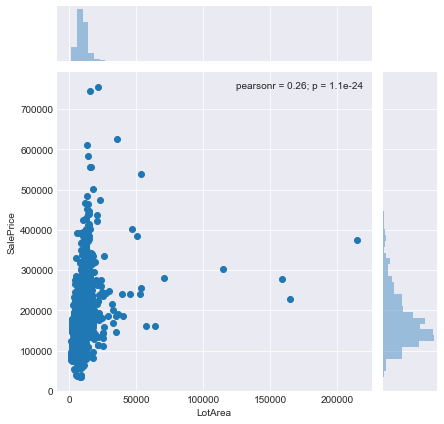

In [229]:
sns.jointplot(data=df_train, x='LotArea', y='SalePrice')

In [230]:
df_train[df_train['LotArea'] > 50000]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
53,20,RL,68.0,50271,Pave,NaN,IR1,Low,AllPub,Inside,Gtl,Veenker,Norm,Norm,1Fam,1Story,9,5,1981,1987,Gable,WdShngl,WdShing,Wd Shng,None,0.0,Gd,TA,CBlock,Ex,TA,Gd,GLQ,1810,Unf,0,32,1842,GasA,Gd,Y,SBrkr,1842,0,0,1842,2,0,0,1,0,1,Gd,5,Typ,1,Gd,Attchd,1981.0,Fin,3,894,TA,TA,Y,857,72,0,0,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal,385000
249,50,RL,NaN,159000,Pave,NaN,IR2,Low,AllPub,CulDSac,Sev,ClearCr,Norm,Norm,1Fam,1.5Fin,6,7,1958,2006,Gable,CompShg,Wd Sdng,HdBoard,BrkCmn,472.0,Gd,TA,CBlock,Gd,TA,Gd,Rec,697,Unf,0,747,1444,GasA,Gd,Y,SBrkr,1444,700,0,2144,0,1,2,0,4,1,Gd,7,Typ,2,TA,Attchd,1958.0,Fin,2,389,TA,TA,Y,0,98,0,0,0,0,NaN,NaN,Shed,500,6,2007,WD,Normal,277000
313,20,RL,150.0,215245,Pave,NaN,IR3,Low,AllPub,Inside,Sev,Timber,Norm,Norm,1Fam,1Story,7,5,1965,1965,Hip,CompShg,BrkFace,BrkFace,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,1236,Rec,820,80,2136,GasW,TA,Y,SBrkr,2036,0,0,2036,2,0,2,0,3,1,TA,8,Typ,2,Gd,Attchd,1965.0,RFn,2,513,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2009,WD,Normal,375000
335,190,RL,NaN,164660,Grvl,NaN,IR1,HLS,AllPub,Corner,Sev,Timber,Norm,Norm,2fmCon,1.5Fin,5,6,1965,1965,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,TA,TA,Gd,ALQ,1249,BLQ,147,103,1499,GasA,Ex,Y,SBrkr,1619,167,0,1786,2,0,2,0,3,1,TA,7,Typ,2,Gd,Attchd,1965.0,Fin,2,529,TA,TA,Y,670,0,0,0,0,0,NaN,NaN,Shed,700,8,2008,WD,Normal,228950
384,60,RL,NaN,53107,Pave,NaN,IR2,Low,AllPub,Corner,Mod,ClearCr,Feedr,Norm,1Fam,2Story,6,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,Av,GLQ,985,Unf,0,595,1580,GasA,Ex,Y,SBrkr,1079,874,0,1953,1,0,2,1,3,1,Gd,9,Typ,2,Fa,Attchd,1992.0,Fin,2,501,TA,TA,Y,216,231,0,0,0,0,NaN,NaN,NaN,0,6,2007,WD,Normal,240000
451,20,RL,62.0,70761,Pave,NaN,IR1,Low,AllPub,Inside,Mod,ClearCr,Norm,Norm,1Fam,1Story,7,5,1975,1975,Gable,WdShngl,Plywood,Plywood,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,655,Unf,0,878,1533,GasA,TA,Y,SBrkr,1533,0,0,1533,1,0,2,0,2,1,Gd,5,Typ,2,TA,Attchd,1975.0,Unf,2,576,TA,TA,Y,200,54,0,0,0,0,NaN,NaN,NaN,0,12,2006,WD,Normal,280000
457,20,RL,NaN,53227,Pave,NaN,IR1,Low,AllPub,CulDSac,Mod,ClearCr,Norm,Norm,1Fam,1Story,4,6,1954,1994,Flat,Tar&Grv,Plywood,Plywood,None,0.0,TA,TA,CBlock,Gd,TA,Gd,BLQ,1116,Unf,0,248,1364,GasA,Ex,Y,SBrkr,1663,0,0,1663,1,0,1,0,2,1,Gd,6,Min1,2,Gd,Attchd,1954.0,Fin,2,529,TA,TA,Y,224,137,0,0,0,0,NaN,NaN,NaN,0,3,2008,WD,Normal,256000
706,20,RL,NaN,115149,Pave,NaN,IR2,Low,AllPub,CulDSac,Sev,ClearCr,Norm,Norm,1Fam,1Story,7,5,1971,2002,Gable,CompShg,Plywood,Plywood,Stone,351.0,TA,TA,CBlock,Gd,TA,Gd,GLQ,1219,Unf,0,424,1643,GasA,TA,Y,SBrkr,1824,0,0,1824,1,0,2,0,2,1,Gd,5,Typ,2,TA,Attchd,1971.0,Unf,2,739,TA,TA,Y,380,48,0,0,0,0,NaN,NaN,NaN,0,6,2007,WD,Normal,302000
769,60,RL,47.0,53504,Pave,NaN,IR2,HLS,AllPub,CulDSac,Mod,StoneBr,Norm,Norm,1Fam,2Story,8,5,2003,2003,Hip,CompShg,CemntBd,Wd Shng,BrkFace,603.0,Ex,TA,PConc,Gd,TA,Gd,ALQ,1416,Unf,0,234,1650,GasA,Ex,Y,SBrkr,1690,1589,0,3279,1,0,3,1,4,1,Ex,12,Mod,1,Gd,BuiltIn,2003.0,Fin,3,841,TA,TA,Y,503,36,0,0,210,0,NaN,NaN,NaN,0,6,2010,WD,Normal,538000
1298,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110

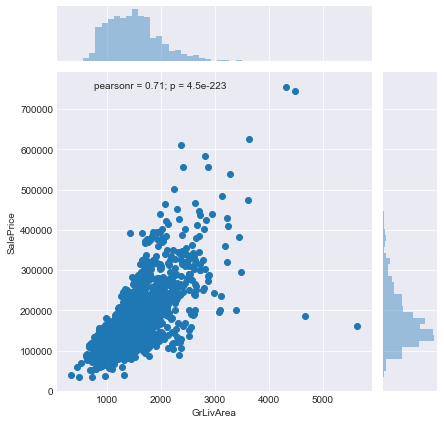

In [231]:
sns.jointplot(data=df_train, x='GrLivArea', y='SalePrice')

In [232]:
df_train[df_train['GrLivArea'] > 4000]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,Stone,762.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2260,Unf,0,878,3138,GasA,Ex,Y,SBrkr,3138,1538,0,4676,1,0,3,1,3,1,Ex,11,Typ,1,Gd,BuiltIn,2007.0,Fin,3,884,TA,TA,Y,208,406,0,0,0,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
691,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,6,1994,1995,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,1455,Unf,0,989,2444,GasA,Ex,Y,SBrkr,2444,1872,0,4316,0,1,3,1,4,1,Ex,10,Typ,2,Ex,Attchd,1994.0,Fin,3,832,TA,TA,Y,382,50,0,0,0,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000
1182,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1996,1996,Hip,CompShg,Wd Sdng,ImStucc,None,0.0,Gd,TA,PConc,Ex,TA,Av,GLQ,2096,Unf,0,300,2396,GasA,Ex,Y,SBrkr,2411,2065,0,4476,1,0,3,1,4,1,Ex,10,Typ,2,TA,Attchd,1996.0,Fin,3,813,TA,TA,Y,171,78,0,0,0,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000
1298,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,GasA,Ex,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2,1418,TA,TA,Y,214,292,0,0,0,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


In [233]:
# Well, these two houses can be considered outliers because they are definitively different from the rest of the neighborhood.
df_train.drop([523, 691, 1182, 1298], inplace=True)

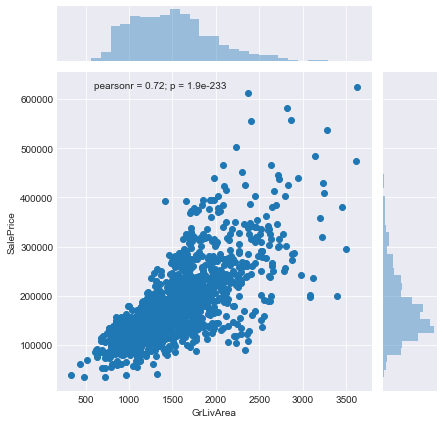

In [234]:
sns.jointplot(data=df_train, x='GrLivArea', y='SalePrice')

----

# Preprocessing

------

In [235]:
train_size = df_train.shape[0]
y_train = df_train['SalePrice']
all_data = pd.concat([df_train, df_test], sort=False)
all_data.drop('SalePrice', axis=1, inplace=True)
print('All Data Set: {},{}'.format(all_data.shape[0], all_data.shape[1]))

All Data Set: 2915,80


## Missing Values

In [236]:
def missing_ratio(df):
    missing = (df.isnull().sum() / df.shape[0]) * 100
    df_nulls = pd.DataFrame(data={'Column': missing.index.values, 'Count': df.isnull().sum().values, 'Ratio': missing.values})
    df_nulls.sort_values(by='Ratio', ascending=False, inplace=True)
    return df_nulls

In [237]:
null_ratios = missing_ratio(all_data)
null_ratios[null_ratios['Count'] > 0]

,Column,Count,Ratio
71,PoolQC,2907,99.725557
73,MiscFeature,2810,96.397942
5,Alley,2717,93.207547
72,Fence,2345,80.445969
79,Id,1456,49.948542
56,FireplaceQu,1420,48.713551
2,LotFrontage,486,16.672384
63,GarageCond,159,5.454545
59,GarageFinish,159,5.454545
62,GarageQual,159,5.454545


##### `PoolQC`, `MiscFeature`, `Alley`, `Fence` and `FireplaceQu` have too many null values. I'm not inputing these features because an input of more than 50% would distort the feature too much. I also dont think they are so important for the predictions.

In [238]:
all_data.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True)

### LotFrontage

In [239]:
by_neighbor = all_data.groupby(by='Neighborhood', sort=True)
by_neighbor.median()['LotFrontage']

Neighborhood
Blmngtn    43.0
Blueste    24.0
BrDale     21.0
BrkSide    51.0
ClearCr    80.5
CollgCr    70.0
Crawfor    70.0
Edwards    64.5
Gilbert    64.0
IDOTRR     60.0
MeadowV    21.0
Mitchel    74.0
NAmes      73.0
NPkVill    24.0
NWAmes     80.0
NoRidge    88.5
NridgHt    92.0
OldTown    60.0
SWISU      60.0
Sawyer     72.0
SawyerW    67.0
Somerst    72.5
StoneBr    60.0
Timber     82.0
Veenker    80.0
Name: LotFrontage, dtype: float64

In [240]:
# Replace the NaN's in LotFrontage with the neighborhood's median.
def neighborhood_median(row):
    median = by_neighbor['LotFrontage'].median()[row['Neighborhood']]
    return median

all_data['LotFrontage'] = all_data.apply(lambda row: neighborhood_median(row) if np.isnan(row['LotFrontage']) else row['LotFrontage'], axis=1)

In [241]:
# Numeric features...
all_data.fillna({'GarageArea': 0, 
                 'GarageCars': 0,
                 'TotalBsmtSF': 0,
                 'BsmtFullBath': 0,
                 'BsmtHalfBath': 0,
                 'BsmtFinSF1': 0,
                 'BsmtFinSF2': 0,
                 'BsmtUnfSF': 0,
                 'MasVnrArea': 0, 
                 'MasVnrType': 'None'}, inplace=True)

# Columns that are going to be filled with the mode.
mode_columns = ['Electrical', 'MSZoning', 'Utilities', 'Functional', 'Exterior1st', 'Exterior2nd', 'SaleType', 'KitchenQual']
for col in mode_columns:
    all_data.fillna({col: all_data[col].mode()[0]}, inplace=True)    

# Replace GarageCond, GarageType, GarageFinish, GarageQual and GarageYrBlt "NaN's" with "NA" when GarageArea = 0;
mask = (all_data['GarageArea'] == 0)
all_data.loc[mask, ['GarageCond','GarageType','GarageFinish','GarageQual','GarageYrBlt']] = "NA"

# Replace GarageCond, GarageType, GarageFinish, GarageQual and GarageYrBlt "NaN's" with "None" when GarageArea > 0;
mask = (all_data['GarageArea'] > 0)
all_data.loc[mask, ['GarageCond','GarageType','GarageFinish','GarageQual','GarageYrBlt']] = "None"

# Replace BsmtQual, BsmtCond, BsmtFinType1, BsmtFinType2 and BsmtExposure "NaN's" with "NA" when TotalBsmtSF = 0;
mask = (all_data['TotalBsmtSF'] == 0)
all_data.loc[mask, ['BsmtQual','BsmtCond','BsmtFinType1','BsmtFinType2','BsmtExposure']] = "NA"

# Replace BsmtQual, BsmtCond, BsmtFinType1, BsmtFinType2 and BsmtExposure "NaN's" with "None" when TotalBsmtSF > 0;
mask = (all_data['TotalBsmtSF'] > 0)
all_data.loc[mask, ['BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'BsmtExposure']] = "None"

In [242]:
# Checking for remaining NaN's
null_ratios = missing_ratio(all_data)
null_ratios[null_ratios['Count'] > 0]

,Column,Count,Ratio
74,Id,1456,49.948542


---

# Exploratory Data Analysis

The objective of this step is to know the data, the relations between the variables and the distributions of the features.

## Numeric Features - Correlation

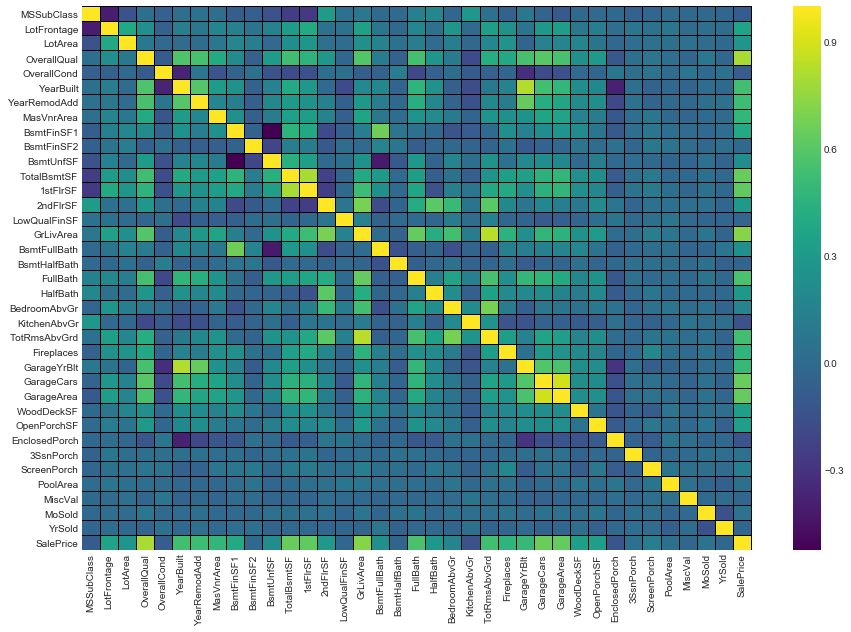

In [243]:
# Plot a heatmap to understand how the features are correlated with the target (SalePrice).
plt.figure(figsize=(15,10))
sns.heatmap(df_train.corr(), cmap='viridis', linewidths=.01, linecolor='black')

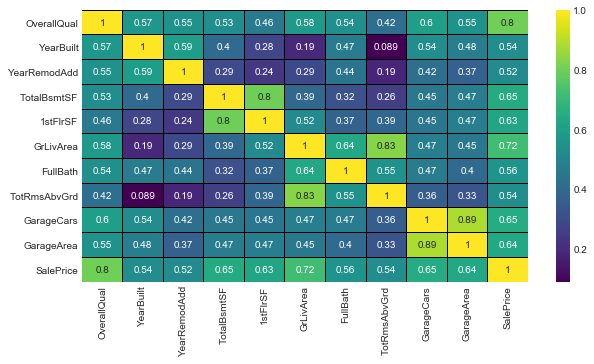

In [244]:
# Selecting the most correlated features with the Sale Price...(0.5 threshold)
price_correlation = df_train.corr()
price_correlation = price_correlation[(price_correlation > 0.5) | (price_correlation < -0.5)]['SalePrice'].dropna()

# Plotting a simplified version of the heatmap for better understanding.
plt.figure(figsize=(10,5))
sns.heatmap(df_train[price_correlation.index].corr(), cmap='viridis', linewidths=.01, annot=True, linecolor='black')

- `OverallQual`, `TotalBsmtSF`, `1stFlrSF`, `GrLivArea`, `GarageCars` and `GarageArea` are the most correlated features w/ `SalePrice`.
- `TotalBsmtSF` and `1stFlrSF` are strongly correlated.
- `GrLivArea` and `TotRmsAbvGrd` are strongly correlated.
- `GarageCars` and `GarageArea`are strongly correlated.

## Categorical Features

In [245]:
categorical_features = df_train.select_dtypes(include=['object']).columns

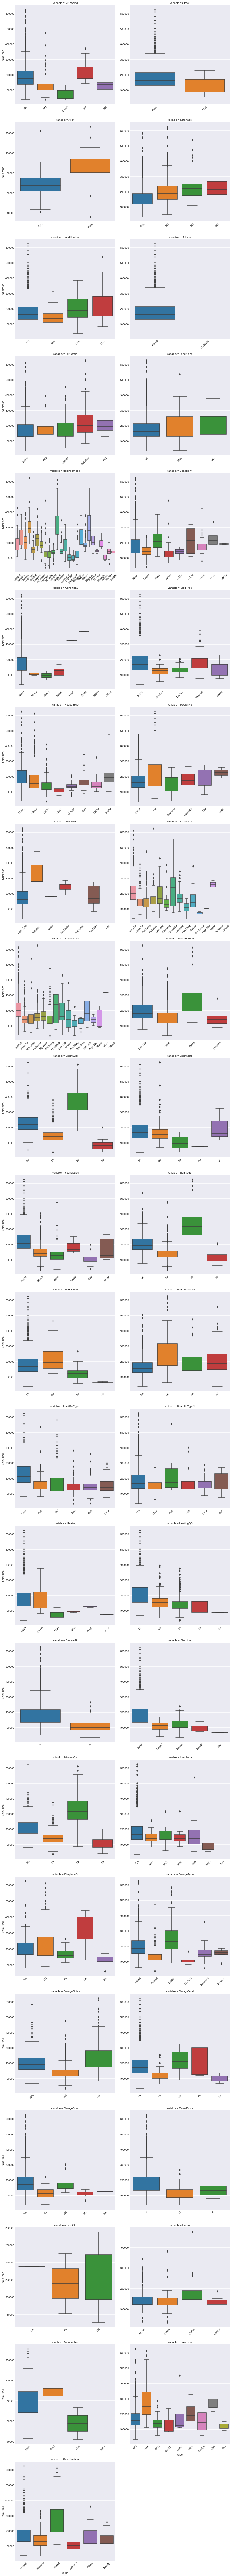

In [246]:
def bxplot(x,y,**kwargs):
    sns.boxplot(x=x,y=y)
    x = plt.xticks(rotation=45)
f = pd.melt(df_train, id_vars=['SalePrice'], value_vars=categorical_features)
g = sns.FacetGrid(f, col='variable', col_wrap=2, size=6, sharex=False, sharey=False,)
g.map(bxplot, 'value', 'SalePrice')

- Since there are a lot of nominal features, with multiple categories, maybe it would be a good ideia to group some of he categories for dimensionality reduction.

## Target Variable

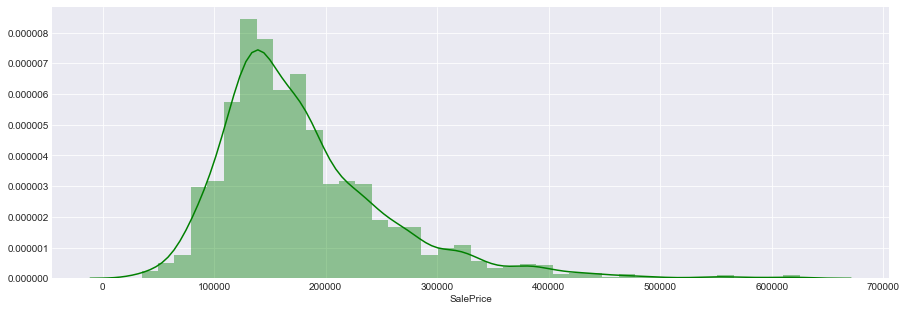

In [247]:
plt.figure(figsize=(15,5))
sns.distplot(df_train['SalePrice'], color='green')

- The target variable `SalePrice` is not normally distributed. A transformation will be required.

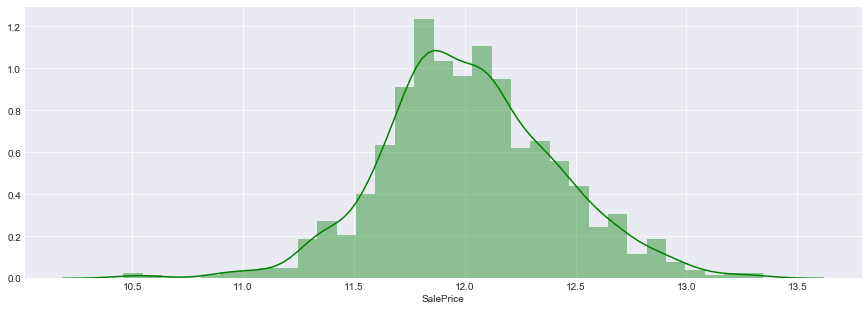

In [248]:
plt.figure(figsize=(15,5))
sns.distplot(np.log(df_train['SalePrice'] ), color='green')

In [249]:
# Applying log transformation.
df_train['SalePrice'] = np.log(df_train['SalePrice'])

## Feature Engineering

In [250]:
# TotalBsmtSF and 1stFlrSF are correlated. What im going to do here is create a new feature (TotalSF), wich 
# corresponds to the sum of the basement, first and second floors and then drop the 3 columns
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data.drop(['TotalBsmtSF','1stFlrSF','2ndFlrSF'], axis=1, inplace=True)

# GrLivArea and TotRmsAbvGr are also correlated. I'm keeping GrLivArea because its correlation with SalePrice is higher
all_data.drop('TotRmsAbvGrd', axis=1, inplace=True)

# GarageCars and GarageArea. Keeping GarageCars since it makes more sense.
all_data.drop('GarageArea', axis=1, inplace=True)

# New feature: House Age
all_data['HouseAge'] = all_data['YrSold'] - all_data['YearBuilt']
all_data.drop(['YrSold','YearBuilt'], axis=1, inplace=True)

# Replacing ordinal features...
ordinal_features = {'GarageCond' : {'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
                    'GarageQual' : {'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
                    'GarageFinish': {'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3},
                    'BsmtExposure': {'NA': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4},
                    'BsmtCond' : {'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
                    'BsmtQual' : {'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
                    'KitchenQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
                    'ExterQual':  {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
                    'ExterCond': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
                    'HeatingQC': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}}

all_data.replace(ordinal_features, inplace=True)

for col in ['GarageCond','GarageQual','GarageFinish','BsmtExposure','BsmtCond','BsmtQual','KitchenQual','ExterQual',
            'ExterCond','HeatingQC']:
    all_data[col] = all_data[col].astype('category')

## Feature Selection

### Numeric Features

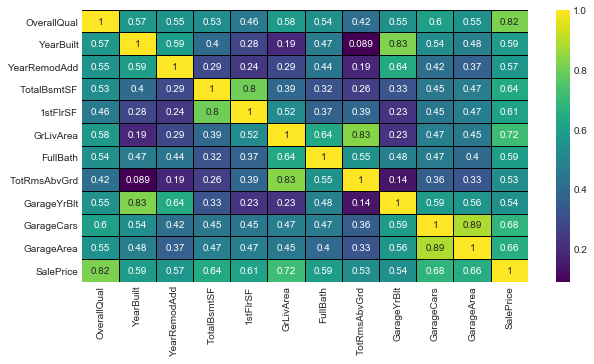

In [251]:
# Checking for multicolinearity and how the new features are related with SalePrice.
price_correlation = df_train.corr()
price_correlation = price_correlation[(price_correlation > 0.5) | (price_correlation < -0.5)]['SalePrice'].dropna()

# Plotting a simplified version of the heatmap for better understanding.
plt.figure(figsize=(10,5))
sns.heatmap(df_train[price_correlation.index].corr(), cmap='viridis', linewidths=.01, annot=True, linecolor='black')

In [252]:
selected_numeric_features = ['OverallQual', 'FullBath', 'GarageCars', 'TotalSF', 'HouseAge']
cols_to_drop = all_data.select_dtypes(exclude=['object','category']).columns.drop(selected_numeric_features)
all_data.drop(cols_to_drop, axis=1, inplace=True)

### Categorical Features

In [253]:
all_data = pd.get_dummies(all_data)

---

## Model / Validation

In [254]:
y_train = df_train['SalePrice']
X_train = all_data[:train_size]
X_test = all_data[train_size:]
print('Train Set: {}, {}'.format(X_train.shape[0], X_train.shape[1]))
print('Test Set: {}, {}'.format(X_test.shape[0], X_test.shape[1]))

Train Set: 1456, 215
Test Set: 1459, 215


In [256]:
# Apllying feature standartization...
train_scaler = StandardScaler()
X_train[X_train.columns] = train_scaler.fit_transform(X_train[X_train.columns])

In [264]:
test_scaler = StandardScaler()
X_test[X_test.columns] = test_scaler.fit_transform(X_test[X_test.columns])

In [383]:
'''
kf = KFold(n_splits=10, random_state=0)
df_alphas = pd.DataFrame(columns=['Alpha', 'RMSE'])
alphas = []

for alpha in np.logspace(-10, 1, 300):
    
    list_mse = []
    rmse = 0
    
    model = Lasso(alpha=alpha)

    for train_index, test_index in kf.split(df_train, y_train):
        X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]

        model.fit(X_train_cv, y_train_cv)
        predictions = model.predict(X_test_cv)
        
        rmse = np.sqrt(mean_squared_error(y_test_cv, predictions))
        list_mse.append(rmse)
                                 
    df_alphas = df_alphas.append({'Alpha': alpha, 'RMSE': np.mean(list_mse)}, ignore_index=True)

df_alphas.sort_values(by='RMSE', inplace=True)
'''

"\nkf = KFold(n_splits=10, random_state=0)\ndf_alphas = pd.DataFrame(columns=['Alpha', 'RMSE'])\nalphas = []\n\nfor alpha in np.logspace(-10, 1, 300):\n    \n    list_mse = []\n    rmse = 0\n    \n    model = Lasso(alpha=alpha)\n\n    for train_index, test_index in kf.split(df_train, y_train):\n        X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]\n        y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]\n\n        model.fit(X_train_cv, y_train_cv)\n        predictions = model.predict(X_test_cv)\n        \n        rmse = np.sqrt(mean_squared_error(y_test_cv, predictions))\n        list_mse.append(rmse)\n                                 \n    df_alphas = df_alphas.append({'Alpha': alpha, 'RMSE': np.mean(list_mse)}, ignore_index=True)\n\ndf_alphas.sort_values(by='RMSE', inplace=True)\n"

In [384]:
#model = Lasso(alpha=0.002) # score: 0.14242

In [385]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure(figsize=(15,5))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("RMSE")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, 
                                                            train_sizes=train_sizes, scoring='neg_mean_squared_error')
    train_scores_mean = -np.mean(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    plt.grid()

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

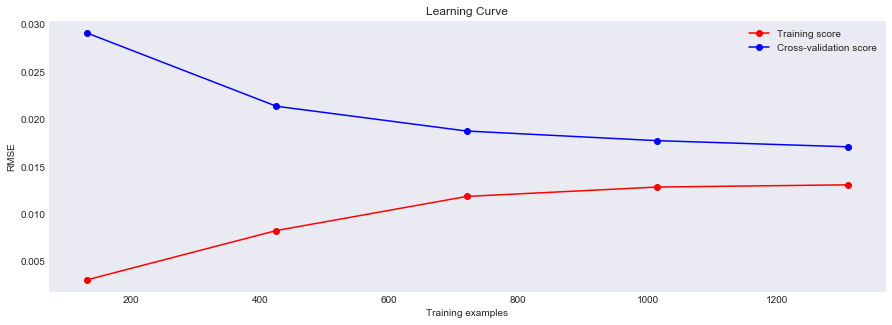

In [386]:
cv = KFold(n_splits=10, random_state=0)
plot_learning_curve(model, 'Learning Curve', X_train, y_train, cv=cv)

## Submission

In [387]:
model.fit(X_train, y_train)
sub_pred = model.predict(X_test)

In [388]:
submission['SalePrice'] = np.exp(sub_pred)
submission.to_csv('submission.csv',index=False)
submission.head()

,Id,SalePrice
0,1461,117611.686466
1,1462,162407.691334
2,1463,168530.690394
3,1464,189178.349747
4,1465,211019.475957
